## Исследовательская часть проекта

### Функции для подготовки и обработки данные

In [183]:
import requests
import pandas as pd
import numpy as np

attributes = {
    'nominal_salary': 'Средняя заработная плата',
    'current_inflation': 'Текущий уровень инфляции',
    'previous_year_inflation': 'Инфляция прошлого года',
    'real_salary': 'Реальный размер заработной платы',
    'real_salary_delta': 'Изменение реальной ЗП'
}
nominal_salary, current_inflation = attributes['nominal_salary'], attributes['current_inflation']
previous_year_inflation, real_salary = attributes['previous_year_inflation'], attributes['real_salary']
real_salary_delta = attributes['real_salary_delta']


In [184]:
def main_pygraph(df, activity):
    """Функция только для JupyterNotebook"""

    import matplotlib.pyplot as plt

    # Создание графика
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Барельеф с заработной платой
    df.plot(x='year', y=real_salary, kind='bar', ax=ax1, color='blue')

    # Линия с инфляцией
    df.plot(x='year', y=previous_year_inflation, kind='line', marker='o', ax=ax2,
                     color='red')
    # Линия с инфляцией
    df.plot(x='year', y=real_salary_delta, kind='line', marker='o', ax=ax2,
                     color='green')

    # Настройка графика
    ax1.set_ylabel(real_salary, color='blue')
    ax2.set_ylabel(previous_year_inflation, color='red')
    ax2.set_ylabel(real_salary_delta, color='green')
    plt.title(f'Заработная плата и инфляция по виду деятельности - {activity.capitalize()}')
    plt.xticks(rotation=45)

In [185]:
def corr_coefficient_extra(df_general, df_extra, extra_column):
    """Функция рассчитывает корреляцию переданных значений в сравнении с значением изменений реальной заработной платы
       используется для работы с дополнительным экономическим показателем
       отличается от аналогичной в приложении"""

    filled_length = len(df_general.merge(df_extra, on='year')) - 2
    delta_salary_list = df_general[real_salary_delta].tolist()[
                        -filled_length:]  # Первое число всегда nan - его мы удаляем
    extra_column_list = df_extra[extra_column].tolist()[
                        -filled_length:]  # не длиннее delta зп

    return str(np.corrcoef(extra_column_list, delta_salary_list)[0, 1])

In [186]:
def corr_coefficient_main(dataframe):
    """Функция рассчитывает корреляцию по единственному датафрейму
       отличается от аналогичной в приложении"""
    delta_salary_list = dataframe[real_salary_delta].tolist()[1:]  # Первое число всегда nan - его мы удаляем
    inflation_last_year_list = dataframe[previous_year_inflation].tolist()[
                              :len(delta_salary_list)]  # не длиннее delta зп
    return str(np.corrcoef(inflation_last_year_list, delta_salary_list)[0, 1])

In [187]:
def clean_numeric_column(value: str):
    """
    Небольшая функция для преобразования числовых значений с запятой в качестве разделителя в стандартный формат
    и для очистки числовых колонок датафреймов от лишних символов
    :param value:
    :return:
    """
    if ',' in value:
        value = value.replace(',', '.')
    value = ''.join(filter(lambda x: x in '1234567890.', value))
    return value

In [188]:
def main_inflation_data() -> pd.DataFrame:
    """
    функция получает данные из основного источника, и распарсевает их как текст
    и возвращает обработанный датафрейм
    :return: адтафрейм с данным по инфляции
    """
    url = """https://xn----ctbjnaatncev9av3a8f8b.xn--p1ai/%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D1%8B-%D0%B8%D0%BD%D1%84%D0%BB%D1%8F%D1%86%D0%B8%D0%B8"""
    r = requests.get(url)
    if r.status_code == 200:
        html_content = r.text
    else:
        print('No connection')
        raise
    # Обработка html до словаря
    inflation_start_line = html_content[html_content.find('yoyInflationList') + len('yoyInflationList":'):]
    inflation_line = inflation_start_line[:inflation_start_line.find(']') + 1].replace('new Date(', '').replace(')', '')
    inflation_list = (eval(inflation_line))

    year_inf = [{'year': record['month'][:4], current_inflation: record['rate']} for record in inflation_list if
                record['month'][5:7] == '12']
    return pd.DataFrame(year_inf, columns=['year', current_inflation])

In [189]:
def alternative_inflation_data() -> pd.DataFrame:
    """
    Альтернативная функция получения данных об инфляции,
    вычитываются сведения об изменении индекса потребительских цен, как самого крупного компонента инфляции
    работает в случае недоступности первого источника
    :return: датафрейм с данным по инфляции
    """
    df = pd.read_excel("https://rosstat.gov.ru/storage/mediabank/ipc_mes_02-2024.xlsx",
                       sheet_name='01', index_col=None)[
         2:18]

    new_df = pd.concat([df.iloc[[0]], df.iloc[[-1]]], ignore_index=True).T

    new_df.reset_index(drop=True, inplace=True)
    new_df.rename(columns={0: 'year', 1: current_inflation}, inplace=True)

    new_df = new_df.dropna(subset=['year'])
    new_df = new_df[['year', current_inflation]].astype(str)
    new_df['year'] = new_df['year'].str.slice(0, 4)
    new_df[current_inflation] = new_df[current_inflation].apply(clean_numeric_column).astype(float) - 100
    return new_df

In [190]:
def economy_activity_data(chosen_activity) -> pd.DataFrame:
    """
    Функция вычитывает данные Росстата о номинальной заработной плате и формирует исторический датафрейм
    :param chosen_activity: список видов эклономической деятельности, выбранных пользователем из доступных
    :return: Датафрейм с данными о номинальных заработных платах по видам экономической деятельнсоти
    """
    df_2016 = pd.read_excel("https://rosstat.gov.ru/storage/mediabank/tab3-zpl_2023.xlsx",
                            sheet_name='2000-2016 гг.', index_col=None)[
              2:]  # первые строки не несут информации для нас
    column_list = ['Вид деятельности', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
                   '2010', '2011', '2012', '2013', '2014', '2015', '2016']
    rename_dict = {df_2016.columns[column_index]: column_list[column_index] for column_index in
                   range(len(df_2016.columns))}
    df_2016.rename(columns=rename_dict, inplace=True)

    # Переименование старых колонок с похожими сферами деятельности
    if 'деятельность гостиниц и предприятий общественного питания' in chosen_activity:
        df_2016['Вид деятельности'] = df_2016['Вид деятельности'] \
            .replace('Операции с недвижимым имуществом, аренда и предоставление услуг',
                     'деятельность гостиниц и предприятий общественного питания')
    if 'деятельность в области здравоохранения и социальных услуг' in chosen_activity:
        df_2016['Вид деятельности'] = df_2016['Вид деятельности'] \
            .replace('Здравоохранение и предоставление социальных услуг',
                     'деятельность в области здравоохранения и социальных услуг')

    # Колонка вид деятельности очищается от регистрозависимости и пробелов
    df_2016['Вид деятельности'] = df_2016['Вид деятельности'].str.lower().str.strip()
    # Подготовка датафрейма с новым данными
    df_2017 = pd.read_excel("https://rosstat.gov.ru/storage/mediabank/tab3-zpl_2023.xlsx", sheet_name='с 2017 г.')[4:]
    rename_dict = {'Unnamed: 0': 'Вид деятельности'}

    # Дополняем словарь с названием колонок через увеличение года на индекс колонки
    [rename_dict.update({df_2017.columns[x]: f"{2016 + x}"}) for x in range(1, len(df_2017.columns))]
    df_2017.rename(columns=rename_dict, inplace=True)
    # Колонка "вид деятельности" очищается от регистрозависимости и пробелов
    df_2017['Вид деятельности'] = df_2017['Вид деятельности'].str.lower().str.strip()
    # Объединяем df и преобразуем годы из столбцов в колонки для удобства соединения с инфляцией
    merged = (pd.merge(df_2016[df_2016['Вид деятельности'].str.lower().str.strip().isin(chosen_activity)],
                       df_2017[df_2017['Вид деятельности'].str.lower().str.strip().isin(chosen_activity)],
                       on='Вид деятельности')
              .melt(id_vars='Вид деятельности', var_name='year', value_name=nominal_salary)
              )
    return merged

In [191]:
def inflation_data() -> pd.DataFrame:
    """
    Функция получает данные об инфляции из основного или альтернативного источника,
    создает колонку с данными об инфляции за предыдущий период

    :return: Датафрейм с данными об инфляции
    """
    try:
        inflation = main_inflation_data()
    except Exception as e:
        inflation = alternative_inflation_data()
    inflation[previous_year_inflation] = inflation[current_inflation].shift(1)
    return inflation

In [192]:
def gross_domestic_product(file_name, result_column) -> pd.DataFrame:
    """
    Функция подготовливает данные о ВВП или данные о ВВП на чел - работает универсально

    :param result_column: Имя колонки в которую будут сохранены результаты подготовки данных
    :param file_name: Название файла на сайте Росстата с выбранным показателем
    :return:
    """
    url = f"https://rosstat.gov.ru/storage/mediabank/{file_name}"

    vvp_old = pd.read_excel(url,
                            sheet_name='1', index_col=None)[1:].T
    vvp_old.rename(columns={1: 'year', 2: 'ВВП в трлн руб.'}, inplace=True)
    vvp_old['year'] = vvp_old['year'].astype(int)
    vvp_old['ВВП в трлн руб.'] = vvp_old['ВВП в трлн руб.'].astype(float)
    vvp_old.reset_index(drop=True, inplace=True)

    vvp = pd.read_excel(url,
                        sheet_name='2', index_col=None)[2:4].T
    vvp.rename(columns={2: 'year', 3: 'ВВП в трлн руб.'}, inplace=True)
    if result_column == 'Изменение ВВП на чел %':
        vvp = pd.read_excel(url, sheet_name='2', index_col=None)[1:3].T
        vvp.rename(columns={1: 'year', 2: 'ВВП в трлн руб.'}, inplace=True)

    vvp = vvp[['year', 'ВВП в трлн руб.']].astype(str)
    vvp['year'] = vvp['year'].str.slice(0, 4)
    vvp['year'] = vvp['year'].astype(int)
    vvp['ВВП в трлн руб.'] = vvp['ВВП в трлн руб.'].astype(float)
    vvp.reset_index(drop=True, inplace=True)

    merged_df = pd.merge(vvp_old, vvp, on=['year', 'ВВП в трлн руб.'], how='outer') \
        .drop_duplicates(subset=['year'], keep='first')  # 2011 расчитывался по обеим методологиями, оставляю первый
    merged_df[result_column] = (merged_df['ВВП в трлн руб.'] - merged_df['ВВП в трлн руб.'].shift(1)) / merged_df[
        'ВВП в трлн руб.'] * 100
    return merged_df

In [193]:
def main(chosen_activity: list) -> pd.DataFrame:
    """
    Основная функция подготовки данных о заработной плате и инфляции

    :param chosen_activity: список видов эклономической деятельности, выбранных пользователем из доступных
    :return: pandas.DataFrame с данными о видах деятельности, номинальную и реальную заработную плату
    """

    # готовим данные
    economy_df = economy_activity_data(chosen_activity)
    inflation_df = inflation_data()
    result = economy_df.merge(inflation_df, on='year')

    # Расчитываем реальную заработную плату
    result[real_salary] = result[nominal_salary] * (
            (100 - result[previous_year_inflation]) / 100)
    # Расчитываем изменение реальной заработной платы во времени
    result[real_salary_delta] = result.groupby('Вид деятельности')[
                                    real_salary].pct_change() * 100
    return result[['year', 'Вид деятельности', real_salary,
                   previous_year_inflation, current_inflation, real_salary_delta]]

In [194]:
def extra_metrics(extra: list) -> dict:
    """
    Функция собирает дополнительные данные из выбранных пользователем показателей

    :param extra: список, выбранных пользователем показателей
    :return: словарь с датафреймом и результирующей колонкой
    """
    result_extra_dict = {}
    if 'ВВП' in extra:
        col = 'Изменение ВВП %'
        result_extra_dict['ВВП'] = {'dataframe': gross_domestic_product(
            file_name="VVP_god_s_1995.xlsx",
            result_column=col),
            'column': col
        }

    if 'ВВП на душу населения' in extra:
        col = 'Изменение ВВП на чел %'
        result_extra_dict['ВВП на душу населения'] = {'dataframe': gross_domestic_product(
            file_name="VVP_na_dushu_s_1995.xlsx",
            result_column=col),
            'column': col
        }
    return result_extra_dict

### Выборка и анализ данных

In [195]:
CHOSEN_ACTIVITY = ['добыча полезных ископаемых', 'обрабатывающие производства', 'строительство',
                   'деятельность гостиниц и предприятий общественного питания', 'образование',
                   'деятельность в области здравоохранения и социальных услуг']
EXTRA_METRICS = ['ВВП', 'ВВП на душу населения']

In [196]:
main_dataframe = main(chosen_activity=CHOSEN_ACTIVITY)

#### Добыча полезных ископаемых

In [197]:
activity = 'добыча полезных ископаемых'
mining = main_dataframe[main_dataframe['Вид деятельности'] == activity]
mining

,year,Вид деятельности,Реальный размер заработной платы,Инфляция прошлого года,Текущий уровень инфляции,Изменение реальной ЗП
0,2000,добыча полезных ископаемых,3768.607894,36.557559,20.200244,NaN
6,2001,добыча полезных ископаемых,7261.139432,20.200244,18.583726,92.674315
12,2002,добыча полезных ископаемых,9021.655857,18.583726,15.056018,24.245732
18,2003,добыча полезных ископаемых,11817.74655,15.056018,11.987855,30.993099
24,2004,добыча полезных ископаемых,14822.741491,11.987855,11.741230,25.427817
30,2005,добыча полезных ископаемых,17410.719267,11.741230,10.914979,17.459508
36,2006,добыча полезных ископаемых,20618.906378,10.914979,8.995778,18.426505
42,2007,добыча полезных ископаемых,25579.011582,8.995778,11.869258,24.056102
48,2008,добыча полезных ископаемых,29264.782285,11.869258,13.281658,14.409355
54,2009,добыча полезных ископаемых,30666.554121,13.281658,8.797004,4.789962


In [198]:
print(f"""Коэффициент корреляции Пирсона между инфляцией прошлого года \n и изменением реальной заработной платы в cфере '{activity.capitalize()}': """,  corr_coefficient_main(mining))


Коэффициент корреляции Пирсона между инфляцией прошлого года 
 и изменением реальной заработной платы в cфере 'Добыча полезных ископаемых':  0.9066068649956184


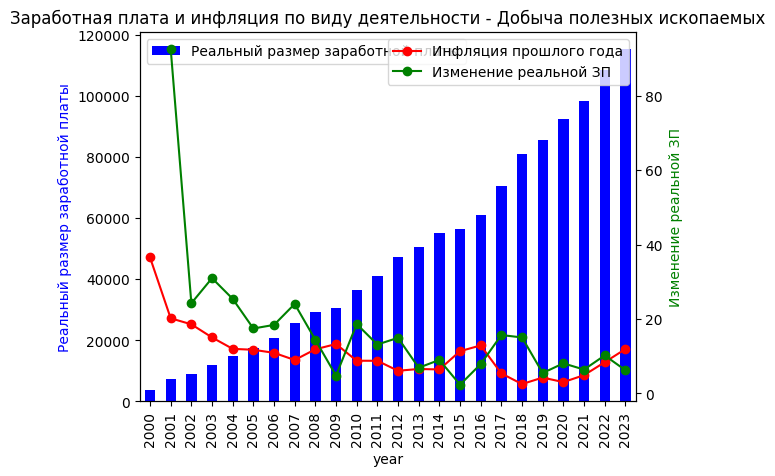

In [199]:
main_pygraph(df=mining, activity=activity)

Предварительный вывод: Инфляция за прошлый год и изменение заработной платы в текущем году в сфере добычи полезных ископаемых имеют очень высокую положительную связь. Реальная заработная плата как правило увеличивается после снижения уровня инфляции

#### Cтроительство

In [200]:
activity = 'строительство'
construction = main_dataframe[main_dataframe['Вид деятельности'] == activity]
construction

,year,Вид деятельности,Реальный размер заработной платы,Инфляция прошлого года,Текущий уровень инфляции,Изменение реальной ЗП
2,2000,строительство,1674.753564,36.557559,20.200244,NaN
8,2001,строительство,3079.711998,20.200244,18.583726,83.890458
14,2002,строительство,3913.598854,18.583726,15.056018,27.07678
20,2003,строительство,5246.734935,15.056018,11.987855,34.064198
26,2004,строительство,6429.023185,11.987855,11.741230,22.53379
32,2005,строительство,7981.064039,11.741230,10.914979,24.141161
38,2006,строительство,9682.829148,10.914979,8.995778,21.322534
44,2007,строительство,13043.999097,8.995778,11.869258,34.712685
50,2008,строительство,16369.404,11.869258,13.281658,25.493753
56,2009,строительство,15715.271356,13.281658,8.797004,-3.996069


In [201]:
print(f"""Коэффициент корреляции Пирсона между инфляцией прошлого года \n и изменением реальной заработной платы в cфере '{activity.capitalize()}'""",  corr_coefficient_main(construction))

Коэффициент корреляции Пирсона между инфляцией прошлого года 
 и изменением реальной заработной платы в cфере 'Строительство' 0.8339388753580377


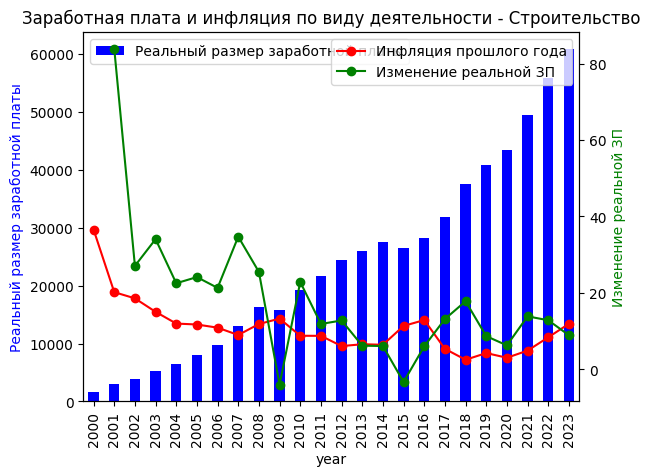

In [202]:
main_pygraph(df=construction, activity=activity)

Предварительный вывод: Инфляция за прошлый год и изменение заработной платы в текущем году в сфере Строительства имеют высокую положительную связь. В периоды роста инфляции рост реально заработной платы замедляется или становится отрицательным. Следует отметить, что 2009 год является скорее выбросом, и оценивать его стоит с учетом макроэкономических процессов в мире, а не только в России

#### Обрабатывающие производства

In [203]:
activity = 'обрабатывающие производства'
manufacturing = main_dataframe[main_dataframe['Вид деятельности'] == activity]
manufacturing

,year,Вид деятельности,Реальный размер заработной платы,Инфляция прошлого года,Текущий уровень инфляции,Изменение реальной ЗП
1,2000,обрабатывающие производства,1500.54062,36.557559,20.200244,NaN
7,2001,обрабатывающие производства,2750.378403,20.200244,18.583726,83.292499
13,2002,обрабатывающие производства,3614.1498,18.583726,15.056018,31.405548
19,2003,обрабатывающие производства,4759.751087,15.056018,11.987855,31.69767
25,2004,обрабатывающие производства,6027.863826,11.987855,11.741230,26.642417
31,2005,обрабатывающие производства,7432.182749,11.741230,10.914979,23.297124
37,2006,обрабатывающие производства,9085.33591,10.914979,8.995778,22.243172
43,2007,обрабатывающие производства,11720.160685,8.995778,11.869258,29.000852
49,2008,обрабатывающие производства,14144.895944,11.869258,13.281658,20.688584
55,2009,обрабатывающие производства,14380.589356,13.281658,8.797004,1.666279


In [204]:
print(f"""Коэффициент корреляции Пирсона между инфляцией прошлого года \n и изменением реальной заработной платы в cфере '{activity.capitalize()}'""",  corr_coefficient_main(manufacturing))

Коэффициент корреляции Пирсона между инфляцией прошлого года 
 и изменением реальной заработной платы в cфере 'Обрабатывающие производства' 0.9110845202065064


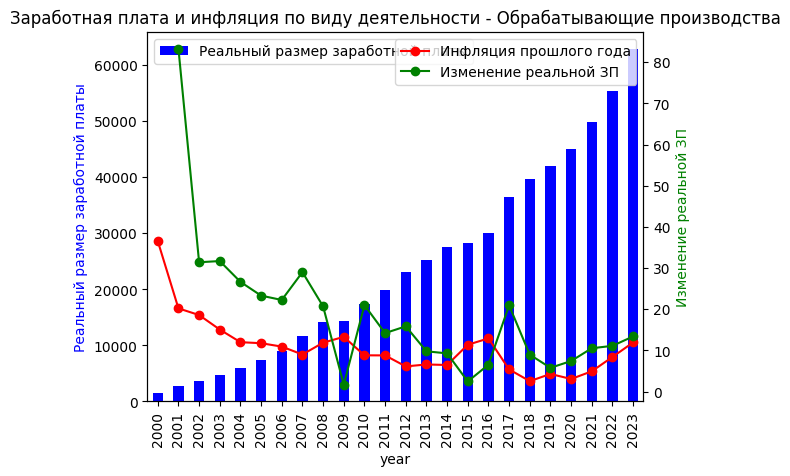

In [205]:
main_pygraph(df=manufacturing, activity=activity)

Предварительный вывод: Инфляция за прошлый год и изменение заработной платы в текущем году в сфере Обрабатывающих производств имеют очень высокую положительную связь. Рост реальной заработной платы как правило ускоряется после снижения уровня инфляции

#### Деятельность гостиниц и предприятий общественного питания

In [206]:
activity = 'деятельность гостиниц и предприятий общественного питания'
tourism = main_dataframe[main_dataframe['Вид деятельности'] == activity]
tourism

,year,Вид деятельности,Реальный размер заработной платы,Инфляция прошлого года,Текущий уровень инфляции,Изменение реальной ЗП
3,2000,деятельность гостиниц и предприятий общественн...,1558.590454,36.557559,20.200244,NaN
9,2001,деятельность гостиниц и предприятий общественн...,2829.380162,20.200244,18.583726,81.53455
15,2002,деятельность гостиниц и предприятий общественн...,3807.920531,18.583726,15.056018,34.584973
21,2003,деятельность гостиниц и предприятий общественн...,5263.383956,15.056018,11.987855,38.222001
27,2004,деятельность гостиниц и предприятий общественн...,6860.898782,11.987855,11.741230,30.351478
33,2005,деятельность гостиниц и предприятий общественн...,9034.873751,11.741230,10.914979,31.686446
39,2006,деятельность гостиниц и предприятий общественн...,11370.099454,10.914979,8.995778,25.846799
45,2007,деятельность гостиниц и предприятий общественн...,15144.558539,8.995778,11.869258,33.196359
51,2008,деятельность гостиниц и предприятий общественн...,18749.815338,11.869258,13.281658,23.805625
57,2009,деятельность гостиниц и предприятий общественн...,19606.756949,13.281658,8.797004,4.5704


In [207]:
print(f"""Коэффициент корреляции Пирсона между инфляцией прошлого года \n и изменением реальной заработной платы в cфере '{activity.capitalize()}'""",  corr_coefficient_main(tourism))

Коэффициент корреляции Пирсона между инфляцией прошлого года 
 и изменением реальной заработной платы в cфере 'Деятельность гостиниц и предприятий общественного питания' 0.6887189864982519


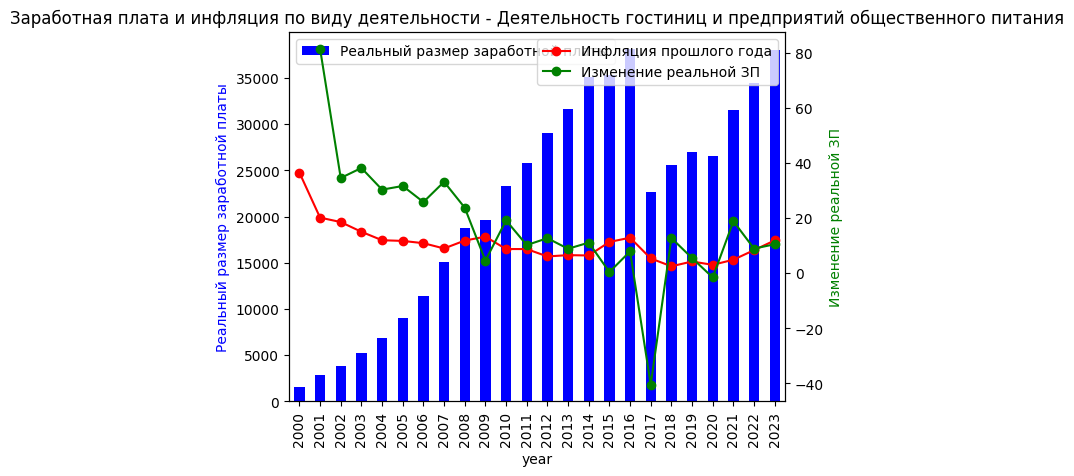

In [208]:
main_pygraph(df=tourism, activity=activity)

Предварительный вывод:
сфера деятельности гостиниц и предприятий общественного питания специально выбрана для наглядности проблем оценки достоверности статистики с учетом изменения методологии, так на графике наглядно виднен существенный провал в 2017 году, вместе с тем в этот год изменились коды ведения деятельности в Российской Федерации и как результат выборка данных по казалось бы схожим предприятиям отрасли стала практически невозможно. Но даже в разврезе до и после смены методологии наглядно видно, что даже небольшой рост инфляции приводит в отрицательному значению роста заработной платы для гостиниц и ресторанов. Поэтому относительно низкий коэффициент корреляции можно объяснить именно выбросом 2017 года.

### Итоговый вывод

* Итоговый вывод: Изменение уровня инфляции в предыдущем году имеет существенное значение для формирования тенденции изменения заработной платы всех отраслей экономики представленных в исследовании. *